In [1]:
import sys
import json
import logging
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ, QuantumCircuit, QuantumRegister, transpile
from qiskit.ignis.mitigation.measurement import complete_meas_cal, MeasurementFilter
from qiskit.providers.ibmq.runtime.utils import RuntimeEncoder, RuntimeDecoder
#from qiskit.providers.ibmq.runtime import UserMessenger

sys.path.append('..')
from main import make_step_circuits, run_forward_circuits, rqd_step, main
from observables import plot_counts_with_curve
from trotter import trotter_step_circuits

## Runtime job input

In [2]:
kwargs = {
    'num_sites': 4,
    'aJ': 1.,
    'am': 0.5,
    'omegadt': 0.2,
    'num_tsteps': 8,
    'tsteps_per_rqd': 2,
    'error_matrix': np.eye(16, dtype='f8'),
    'physical_qubits': None,
    'minimizer_shots': 4096,
    'forward_shots': 2 * 8192,
    'max_sweeps': 100
}

logging.getLogger('four_qubit_schwinger').setLevel(logging.INFO)

## Testing just the forward steps

2021-11-03 00:27:33,194: Running 8 circuits, 16384 shots per experiment, 8 experiments
2021-11-03 00:27:36,020: Forward circuit results returned


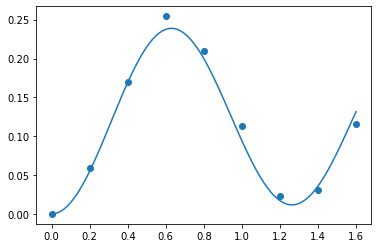

In [3]:
backend = Aer.get_backend('statevector_simulator')

num_sites = kwargs['num_sites']
aJ = kwargs['aJ']
am = kwargs['am']
omegadt = kwargs['omegadt']
num_tsteps = kwargs['num_tsteps']
physical_qubits = kwargs['physical_qubits']
error_matrix = kwargs['error_matrix']
forward_shots = kwargs['forward_shots']

_, state_labels = complete_meas_cal(qubit_list=list(range(num_sites)), qr=QuantumRegister(num_sites), circlabel='mcal')
error_mitigation_filter = MeasurementFilter(error_matrix, state_labels)

forward_circuits = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)

target_circuits = trotter_step_circuits(num_tsteps, forward_circuits, initial_state=None, measure=False)

counts_list = run_forward_circuits(target_circuits, backend, initial_layout=physical_qubits, shots=forward_shots, error_mitigation_filter=error_mitigation_filter)

plot_counts_with_curve(counts_list, num_sites, aJ, am, omegadt, num_tsteps, initial_state=None, num_toys=0)

## Testing one RQD step

In [4]:
backend = Aer.get_backend('qasm_simulator')

num_sites = kwargs['num_sites']
aJ = kwargs['aJ']
am = kwargs['am']
omegadt = kwargs['omegadt']
tsteps_per_rqd = kwargs['tsteps_per_rqd']
max_sweeps = kwargs['max_sweeps']
minimizer_shots = kwargs['minimizer_shots']
forward_shots = kwargs['forward_shots']
physical_qubits = kwargs['physical_qubits']
error_matrix = kwargs['error_matrix']

_, state_labels = complete_meas_cal(qubit_list=list(range(num_sites)), qr=QuantumRegister(num_sites), circlabel='mcal')
error_mitigation_filter = MeasurementFilter(error_matrix, state_labels)

forward_circuits = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)

step_res = rqd_step(tsteps_per_rqd, forward_circuits, backend, physical_qubits, max_sweeps, minimizer_shots, forward_shots, error_mitigation_filter, None)
        

In [21]:
forward_counts, optimal_params, total_shots, shots_values, cost_values = step_res

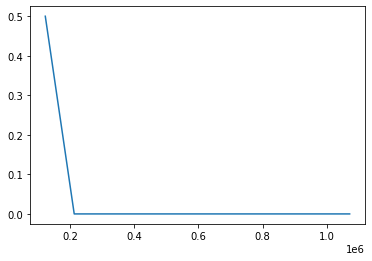

In [5]:
plt.plot(shots_values, cost_values)

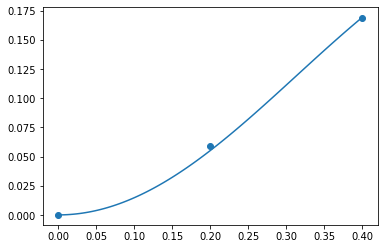

In [6]:
plot_counts_with_curve(forward_counts, num_sites, aJ, am, omegadt, tsteps_per_rqd, initial_state=None, num_toys=0)

In [7]:
step_res_2 = rqd_step(tsteps_per_rqd, forward_circuits, backend, physical_qubits, max_sweeps, minimizer_shots, forward_shots, error_mitigation_filter, optimal_params)
        

In [18]:
forward_counts_2, optimal_params_2, total_shots_2, shots_values_2, cost_values_2 = step_res_2

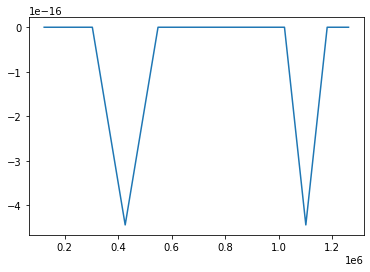

In [19]:
plt.plot(shots_values_2, cost_values_2)

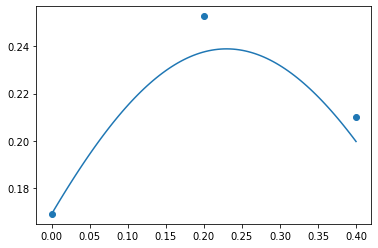

In [20]:
from hamiltonian import schwinger_model, diagonalized_evolution

vacuum_state = np.zeros(2 ** num_sites, dtype=np.complex128)
vacuum_state_index = 0
for j in range(0, num_sites, 2):
    vacuum_state_index += (1 << j)
vacuum_state[vacuum_state_index] = 1.

hamiltonian = schwinger_model(num_sites, aJ, am)
_, statevectors = diagonalized_evolution(hamiltonian, vacuum_state, omegadt * tsteps_per_rqd)
plot_counts_with_curve(forward_counts_2, num_sites, aJ, am, omegadt, tsteps_per_rqd, initial_state=statevectors[:, -1], num_toys=0)

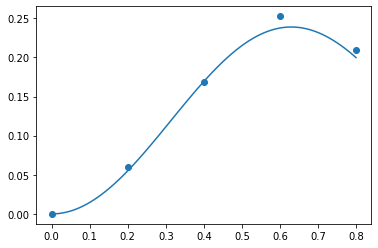

In [22]:
plot_counts_with_curve(forward_counts + forward_counts_2, num_sites, aJ, am, omegadt, tsteps_per_rqd * 2, initial_state=None, num_toys=0)

class UserMessenger:
    """Base class for handling communication with program users.

    This class can be used when writing a new Qiskit Runtime program.
    """

    def publish(
            self,
            message: Any,
            encoder: Type[json.JSONEncoder] = RuntimeEncoder,
            final: bool = False
    ) -> None:
        """Publish message.

        You can use this method to publish messages, such as interim and final results,
        to the program user. The messages will be made immediately available to the user,
        but they may choose not to receive the messages.

        The `final` parameter is used to indicate whether the message is
        the final result of the program. Final results may be processed differently
        from interim results.

        Args:
            message: Message to be published. Can be any type.
            encoder: An optional JSON encoder for serializing
            final: Whether the message being published is the final result.
        """
        # pylint: disable=unused-argument
        # Default implementation for testing.
        print(json.dumps(message, cls=encoder))

#J=2, mu=2, omegadt=0.05 dt=
#J=g^2 a^2 / 2
#mu=m a
#omega=1/2a


    

user_messenger = UserMessenger()
serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

forward_counts_list, optimal_params_list = main(backend, user_messenger, **deserialized_inputs)